In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

import kagglehub

In [2]:
#  Linear Regression
# Naudojamas seaborn pateikiamas duomenų rinkinys. Užduotis:
# Sukurti tiesinės regresijos modelį, kuris prognozuotų automobilio
# degalų suvartojimą (mpg - miles per gallon).
# Pridėkite vartotojo įvestį

mpg = sns.load_dataset('mpg')
mpg.dropna(inplace=True)
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [3]:
ori = pd.get_dummies(mpg['origin'], dtype=int)
mpg2 = pd.concat([mpg, ori], axis=1)

X = mpg2.drop(columns=['origin', 'name', 'mpg'])
y = mpg2['mpg'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

fit = LinearRegression().fit(X_train, y_train)
predicted = fit.predict(X_test)

spejimai = pd.Series(data=predicted, name='Spejimai')
orig_rez = pd.Series(data=y_test, name='Ytest')
res = pd.concat([orig_rez.reset_index(drop=True), spejimai], axis=1)
res.head()

,Ytest,Spejimai
0,26.0,27.356332
1,21.6,27.057310
2,36.1,34.524493
3,26.0,24.684753
4,27.0,28.042054


In [4]:
fit.score(X_test, y_test) *100

79.64817032975604

<Axes: >

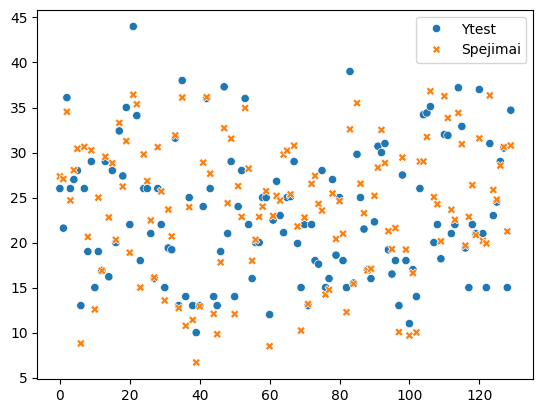

In [5]:
sns.scatterplot(data=res)

In [7]:
cylinder = 6
displacement = 307
horsepower = 130
weight = 3504
accel = 12
year = 70
eu = 0
jp = 0
usa = 1


ats = fit.predict(np.reshape([cylinder, displacement, horsepower, weight, accel, year, eu, jp, usa], (1, -1)))
print(f'mpg: {float(ats):.2f}')

mpg: 15.78


fit score: 22.284316333100485


<Axes: >

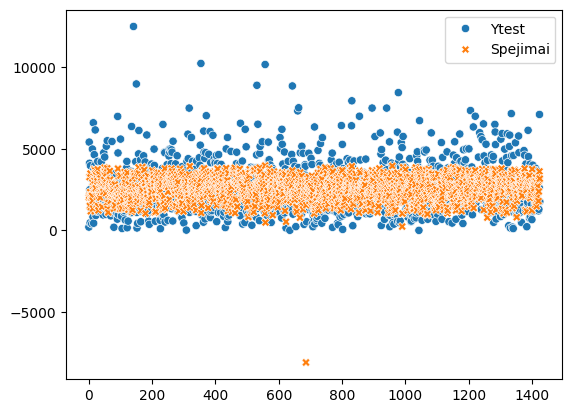

In [11]:
# Linear Regression su LabelEncoder()

SDB = sqlite3.connect('aruodas.db')
C = SDB.cursor()
sql = """select * from Aruodas;"""
df = pd.read_sql_query(sql, con=SDB)
SDB.close()

def plotas(x):
    # if 'm²' in x:
    if x is not None:
        return float(x.replace(' m²', '',).replace(',', '.'))
    else:
        return np.nan
    
df['plotas'] = df['Plotas:'].apply(plotas)

def amzius(x):
    return  2024 - int(x[:4])

df['amzius'] = df['Metai:'].apply(amzius)

aruodas = df[['miestas', 'rajonas', 'gatve', 'kaina', 'kv_kaina', 'Kambarių sk.:',
       'Aukštas:', 'Aukštų sk.:', 'Pastato tipas:', 'Šildymas:',
       'Įrengimas:','plotas', 'amzius']]
aruodas.dropna(inplace=True)

aruodas['Kambarių sk.:'] = aruodas['Kambarių sk.:'].apply(lambda x: int(x))
aruodas['Aukštas:'] = aruodas['Aukštas:'].apply(lambda x: int(x))
aruodas['Aukštų sk.:'] = aruodas['Aukštų sk.:'].apply(lambda x: int(x))

# pasiziureti kaip suzymi
# label_encoder = LabelEncoder()
# data = aruodas['Šildymas:']
# encoded_data = label_encoder.fit_transform(data)
# print('Category Mapping:', dict(zip(data, encoded_data)))
# aruodas.head()

l = LabelEncoder().fit_transform(aruodas['miestas'])
aruodas['miestas'] = l
l = LabelEncoder().fit_transform(aruodas['rajonas'])
aruodas['rajonas'] = l
l = LabelEncoder().fit_transform(aruodas['gatve'])
aruodas['gatve'] = l
l = LabelEncoder().fit_transform(aruodas['Pastato tipas:'])
aruodas['Pastato tipas:'] = l
l = LabelEncoder().fit_transform(aruodas['Šildymas:'])
aruodas['Šildymas:'] = l
l = LabelEncoder().fit_transform(aruodas['Įrengimas:'])
aruodas['Įrengimas:'] = l
aruodas.head()

# kai duomenys sutvarkyti
# taikomas modelis
X = aruodas.drop(columns=['kaina', 'kv_kaina'])
y = aruodas['kv_kaina'].values      # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

fit = LinearRegression().fit(X_train, y_train)
predicted = fit.predict(X_test)

spejimai = pd.Series(data=predicted, name='Spejimai')
orig_rez = pd.Series(data=y_test, name='Ytest')
res = pd.concat([orig_rez.reset_index(drop=True), spejimai], axis=1)

fit_score = fit.score(X_test, y_test) *100.0
print(f'fit score: {fit_score}')
sns.scatterplot(data=res)






fit score: -0.9461276489110197


<Axes: >

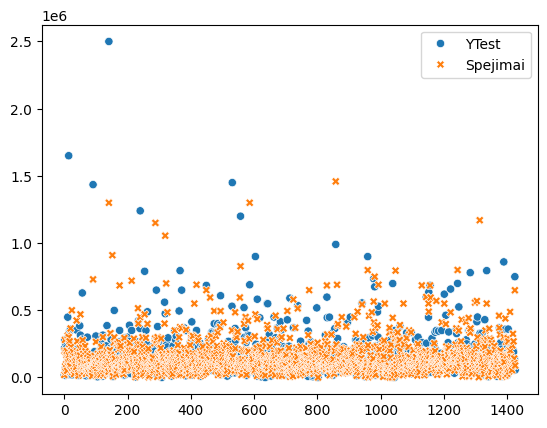

In [9]:
# Decision Tree
SDB = sqlite3.connect('aruodas.db')
C = SDB.cursor()
sql="""select *   from Aruodas;"""
df = pd.read_sql_query(sql, con=SDB)

SDB.close()

def plotas(x):
    # if 'm²' in x:
    if x is not None:
        return float(x.replace(' m²', '',).replace(',', '.'))
    else:
        return np.nan
    
df['plotas'] = df['Plotas:'].apply(plotas)

def amzius(x):
    return  2024 - int(x[:4])

df['amzius'] = df['Metai:'].apply(amzius)

aruodas = df[['miestas', 'rajonas', 'gatve', 'kaina', 'kv_kaina', 'Kambarių sk.:',
       'Aukštas:', 'Aukštų sk.:', 'Pastato tipas:', 'Šildymas:',
       'Įrengimas:','plotas', 'amzius']]
aruodas.dropna(inplace=True)

aruodas['Kambarių sk.:'] = aruodas['Kambarių sk.:'].apply(lambda x: int(x))
aruodas['Aukštas:'] = aruodas['Aukštas:'].apply(lambda x: int(x))
aruodas['Aukštų sk.:'] = aruodas['Aukštų sk.:'].apply(lambda x: int(x))

l = LabelEncoder().fit_transform(aruodas['miestas'])
aruodas['miestas'] = l
l = LabelEncoder().fit_transform(aruodas['rajonas'])
aruodas['rajonas'] = l
l = LabelEncoder().fit_transform(aruodas['gatve'])
aruodas['gatve'] = l
l = LabelEncoder().fit_transform(aruodas['Pastato tipas:'])
aruodas['Pastato tipas:'] = l
l = LabelEncoder().fit_transform(aruodas['Šildymas:'])
aruodas['Šildymas:'] = l
l = LabelEncoder().fit_transform(aruodas['Įrengimas:'])
aruodas['Įrengimas:'] = l

X = aruodas.drop(columns=['kaina', 'kv_kaina'])
y = aruodas['kaina'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# DecisionTreeRegressor nes vertinsime skaiciu
regressor = DecisionTreeRegressor(random_state=23)
regressor.fit(X_train, y_train)

# Predictic using the trained model
predicted = regressor.predict(X_test)

# Convert predictions and actual values to pandas Series for comparison
spejimai = pd.Series(data=predicted, name='Spejimai')
orig_rez = pd.Series(data=y_test, name='YTest')

# Combine the predictions and actual values into a DataFrame
res = pd.concat([orig_rez.reset_index(drop=True), spejimai], axis=1)
# Calculate the R^2 score
fit_score = fit.score(X_test, y_test)
print(f'fit score: {fit_score}')

sns.scatterplot(data=res)


rmse	3.072743608208423	r2	0.9996788340617946


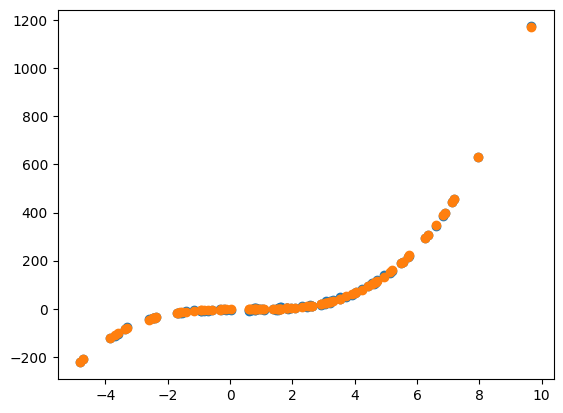

In [12]:
# Polinomine regresija

np.random.seed(0)
x = 2-3*np.random.normal(0,1,100)
y = x-2*(x**2)+1.5*(x**3)+np.random.normal(-3,3,100)
x = x[:, np.newaxis]

# plt.scatter(x, y)
# plt.show()

poly_features = PolynomialFeatures(degree=3)
x_poly = poly_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)

y_poly_predicted = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y, y_poly_predicted))
r = model.score(x_poly, y)
print('rmse', rmse, 'r2', r, sep='\t')

plt.scatter(x, y)
plt.scatter(x, y_poly_predicted)
plt.show()

In [13]:
# Logistical Regression
path = kagglehub.dataset_download("taweilo/loan-approval-classification-data")
print("Path to dataset files:", path)
df = pd.read_csv(path+"/loan_data.csv")
df.head()


Path to dataset files: C:\Users\Lukas\.cache\kagglehub\datasets\taweilo\loan-approval-classification-data\versions\1


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Logistic Regression model accuracy (in %): 81.89999999999999


<Axes: >

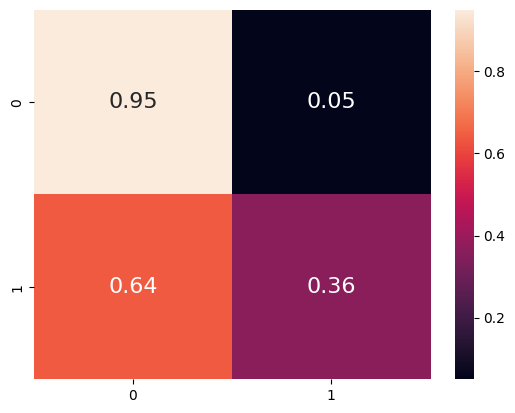

In [14]:
categorical_columns = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent','previous_loan_defaults_on_file' ]

label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Define features (X) and target (y)
X = df.drop(columns=['loan_status','previous_loan_defaults_on_file'])  # Features
y = df['loan_status']  # Target (Loan approval: Y/N)

X_train, X_test, \
y_train, y_test = train_test_split(X, y, test_size=0.20,
                                   random_state=23)

# LogisticalRegression
clf = LogisticRegression(random_state=0)
# train the model
clf.fit(X_train, y_train)

# prediction
y_pred = clf.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
print("Logistic Regression model accuracy (in %):", acc*100)

# class_report = classification_report(y_test, y_pred)
# print('Classification Report:')
# print(class_report)

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(data=cm, annot=True, annot_kws={'fontsize':16})


In [16]:
# Fraud pvz
#  tree ir logistic regression palyginimas
path = kagglehub.dataset_download("jainilcoder/online-payment-fraud-detection")
print("Path to dataset files:", path)
df = pd.read_csv(path+"/onlinefraud.csv")

categorical_columns = ['type', 'nameDest', 'nameOrig']
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

Path to dataset files: C:\Users\Lukas\.cache\kagglehub\datasets\jainilcoder\online-payment-fraud-detection\versions\1


Logistic Regression model accuracy (in %): 99.90821391187907


<Axes: >

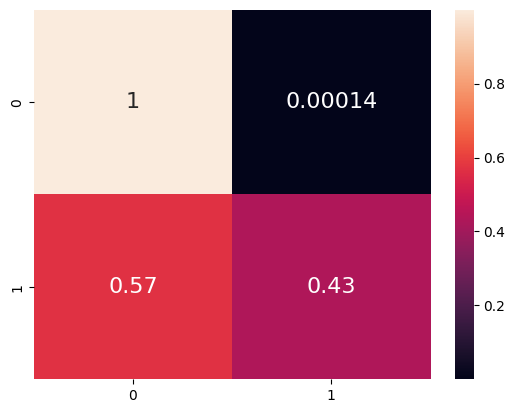

In [17]:

# LogisticRegression
    
X = df.drop(columns=['isFraud',])  # Features
y = df['isFraud']  # Target (Loan approval: Y/N)

X_train, X_test,\
y_train, y_test = train_test_split(X, y,
test_size=0.20,
random_state=23)

# LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
# prediction
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Logistic Regression model accuracy (in %):", acc*100)

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(data=cm, annot=True, annot_kws={'fontsize':16})


score: 99.96856641416608 %


<Axes: >

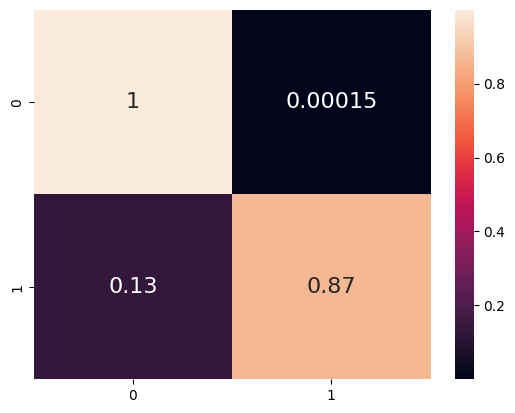

In [19]:
# Decision tree
# DecisionTreeClasifier (kai ieškom atsakymo pvz. Taip / Ne)
X = df.drop(columns=['isFraud',])  # Features
y = df['isFraud']  # Target (Loan approval: Y/N)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'score: {accuracy *100} %')

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(data=cm,annot=True, annot_kws={'fontsize':16})